In [60]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [61]:
image = cv2.imread("./upstairs1_5.png")
# image = cv2.imread("./table_footage.jpg")
print(image.shape)

(1080, 1920, 3)


(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)
(1080, 1920, 3)


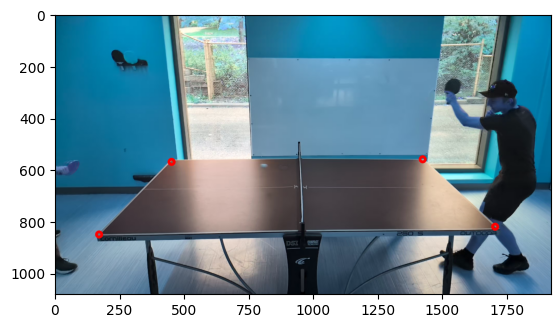

In [62]:
corners = [[450, 570], [1420, 560], [1700, 820], [170, 850]]
draw_image = image.copy()
for corner in corners:
    print(image.shape)
    draw_image = cv2.circle(draw_image, corner, 10, (255, 0, 0), 10)
plt.imshow(draw_image)

In [63]:
# corners = [[350, 540], [1250, 540], [1540, 800], [90, 800]]
# draw_image = image.copy()
# for corner in corners:
#     print(image.shape)
#     draw_image = cv2.circle(draw_image, corner, 10, (255, 0, 0), 10)
# plt.imshow(draw_image)

In [64]:
import numpy as np

def compute_homography(pts_src, pts_dst):
    """DLT homography: src (Nx2) -> dst (Nx2)"""
    pts_src = np.asarray(pts_src, dtype=float)
    pts_dst = np.asarray(pts_dst, dtype=float)
    A = []
    for (x,y),(u,v) in zip(pts_src, pts_dst):
        A.append([-x, -y, -1,  0,  0,  0, x*u, y*u, u])
        A.append([ 0,  0,  0, -x, -y, -1, x*v, y*v, v])
    A = np.asarray(A)
    _, _, Vt = np.linalg.svd(A)
    h = Vt[-1,:]
    H = h.reshape(3,3)
    return H / H[2,2]

def focal_error(f_px, H, cx, cy):
    """Scalar error (squared) from the two orthogonality/norm constraints."""
    K_inv = np.array([[1.0/f_px, 0.0, -cx/f_px],
                      [0.0, 1.0/f_px, -cy/f_px],
                      [0.0, 0.0, 1.0]])
    h1 = H[:,0]; h2 = H[:,1]
    r1 = K_inv @ h1
    r2 = K_inv @ h2
    e1 = float(np.dot(r1, r2))                    # should be 0
    e2 = float(np.dot(r1, r1) - np.dot(r2, r2))   # should be 0
    return e1*e1 + e2*e2

def find_f_from_homography(H, cx, cy, f_min=1.0, f_max=20000.0, nsamples=2000):
    # coarse log-space scan then local linear refine
    xs = np.logspace(np.log10(f_min), np.log10(f_max), nsamples)
    errs = np.array([focal_error(x, H, cx, cy) for x in xs])
    idx = np.argmin(errs)
    lo = max(f_min, xs[max(0, idx-5)])
    hi = min(f_max, xs[min(nsamples-1, idx+5)])
    fine_xs = np.linspace(lo, hi, 200)
    fine_errs = np.array([focal_error(x, H, cx, cy) for x in fine_xs])
    idx2 = np.argmin(fine_errs)
    return float(fine_xs[idx2]), float(fine_errs[idx2])

def calculate_focal_mm(pts_img, table_dims_ft, principal_pt_px,
                       sensor_width_mm=6.3, image_width_px=None):
    ft_to_m = 0.3048
    L = table_dims_ft[0] * ft_to_m
    W = table_dims_ft[1] * ft_to_m
    world_pts = np.array([[0,0],[L,0],[L,W],[0,W]], dtype=float)
    img_pts = np.asarray(pts_img, dtype=float)
    if image_width_px is None:
        image_width_px = 2.0 * principal_pt_px[0]  # assume cx near center
    H = compute_homography(world_pts, img_pts)
    H = H / np.linalg.norm(H[:,0])  # numerical stability
    cx, cy = principal_pt_px
    best_f_px, err = find_f_from_homography(H, cx, cy)
    f_mm = best_f_px * (sensor_width_mm / image_width_px)
    return best_f_px, f_mm, err, H


In [65]:
table = (9.0, 5.0)                # feet
cx_cy = (image.shape[1] // 2, image.shape[0] // 2)          # principal point (px)
f_px, f_mm, err, H = calculate_focal_mm(corners, table, cx_cy,
                                        sensor_width_mm=6.3,)
print(f_px, f_mm, err)

1403.8335378258125 4.606328795990947 1.2322209544591408e-16


In [66]:
image_length = image.shape[1]
image_width = image.shape[0]
focal_len = calculate_focal_mm(corners, (9, 5), (image_length // 2, image_width // 2), sensor_width_mm=6.3)

In [67]:
focal_len

(1403.8335378258125,
 4.606328795990947,
 1.2322209544591408e-16,
 array([[ 9.99960722e-01, -6.06808688e-01,  1.21227686e+00],
        [ 8.86307392e-03, -6.43363428e-02,  1.53555069e+00],
        [ 3.33634534e-05, -6.57985324e-04,  2.69394858e-03]]))